In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/street/1269.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/2193.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/sea/19812.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/forest/7981.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/glacier/12666.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/6234.jpg
/kaggle/input/intel-image-classification/seg_test/seg_test/mountain/22608.jpg
/kaggle/input/intel-image-classification/seg_test/seg_test/street/20088.jpg
/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/22735.jpg
/kaggle/input/intel-image-classification/seg_test/seg_test/sea/20513.jpg
/kaggle/input/intel-image-classification/seg_test/seg_test/forest/23407.jpg
/kaggle/input/intel-image-classification/seg_test/seg_test/glacier/23149.jpg


## Description

In this competition, participants will work with four datasets: training, validation, test, and comp_test. The training dataset contains labeled data that competitors will use to train their models. The validation dataset allows them to fine-tune their models and assess performance during development. The test dataset provides an additional benchmark to estimate how well their models generalize to unseen data. However, the comp_test dataset is different—it consists of unlabeled data for which participants must generate predictions. Their final task is to submit predictions for this dataset, which will be evaluated against hidden ground-truth labels to determine the competition rankings.

In [23]:
#Import deep learning libraries

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from PIL import Image
import time
from tqdm import tqdm


# **Step 1: Competition Data Curation and Preprocessing** 

## Image Preprocessing Pipeline

The transformation pipeline is designed to preprocess images before feeding them into a machine learning model. The steps involved are:

1. **Convert to Grayscale**:  
   `transforms.Grayscale(num_output_channels=1)` ensures all images have a single channel, simplifying processing for models that do not require color information.

2. **Resize to a Fixed Dimension**:  
   `transforms.Resize((150, 150))` resizes all images to a standard size of **150x150 pixels**, ensuring consistency across the dataset.

3. **Convert to Tensor**:  
   `transforms.ToTensor()` converts images into **PyTorch tensors**, normalizing pixel values to the `[0,1]` range.

4. **Normalize Pixel Values**:  
   `transforms.Normalize(mean=[0.5], std=[0.5])` standardizes pixel values to have a **zero mean** and a range approximately from `[-1,1]`. This helps stabilize training and improve model performance.

This preprocessing ensures uniformity across the dataset and enhances the model’s ability to learn meaningful features.


In [24]:
# Define the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((150, 150)),                # Resize images to 150x150
    transforms.ToTensor(),                        # Convert images to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize images to [0, 1]
])

## Training Dataset Preparation

1. **Define the Training Dataset Path**:  
   The dataset is stored in the directory `/kaggle/input/intel-image-classification/seg_train/seg_train`, which contains images organized into subfolders representing different classes.

2. **Load the Dataset Using `ImageFolder`**:  
   `datasets.ImageFolder(root=train_path, transform=transform)` automatically assigns labels based on subfolder names and applies the predefined transformations.

3. **Define the Batch Size**:  
   A `batch_size` of `32` is set, meaning the model will process 32 images at a time during training.

4. **Create the DataLoader**:  
   `DataLoader(train_dataset, batch_size=batch_size, shuffle=True)` creates an iterable that loads data in mini-batches. The `shuffle=True` ensures that the dataset is randomly shuffled at each epoch, improving generalization and preventing overfitting.

This setup enables efficient data loading, ensuring that images are properly processed and fed into the model during training.


In [25]:
#train dataset
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train'
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
# Define batch size
batch_size = 64
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Example: Iterate over the first batch
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 150, 150]) torch.Size([64])


## Visualizing Sample Images from the Training Dataset

This block of code retrieves a batch of images from the `train_loader`, denormalizes them, and plots a subset to visually inspect the dataset.

### **Steps:**
1. **Iterate Over the DataLoader**:  
   The loop extracts a batch of `images` and their corresponding `labels` from the `train_loader`.

2. **Denormalize the Images**:  
   Since the dataset was normalized using `mean=[0.5], std=[0.5]`, the images are denormalized using `images = images * 0.5 + 0.5`, bringing pixel values back to their original scale `[0,1]` for correct visualization.

3. **Plot the Images**:  
   - `plt.figure(figsize=(10, 10))` sets the figure size.
   - A loop runs 9 times to plot the first 9 images.
   - `plt.imshow(images[i][0], cmap='gray')` ensures grayscale images are displayed correctly.
   - `plt.title(f"Label: {labels[i].item()}")` assigns a title with the corresponding label.
   - `plt.axis('off')` removes axis ticks for better visualization.

4. **Show the Images and Stop the Loop**:  
   The `break` statement ensures that only the first batch of images is displayed.

This visualization step helps in understanding the dataset distribution and verifying preprocessing transformations before training the model.


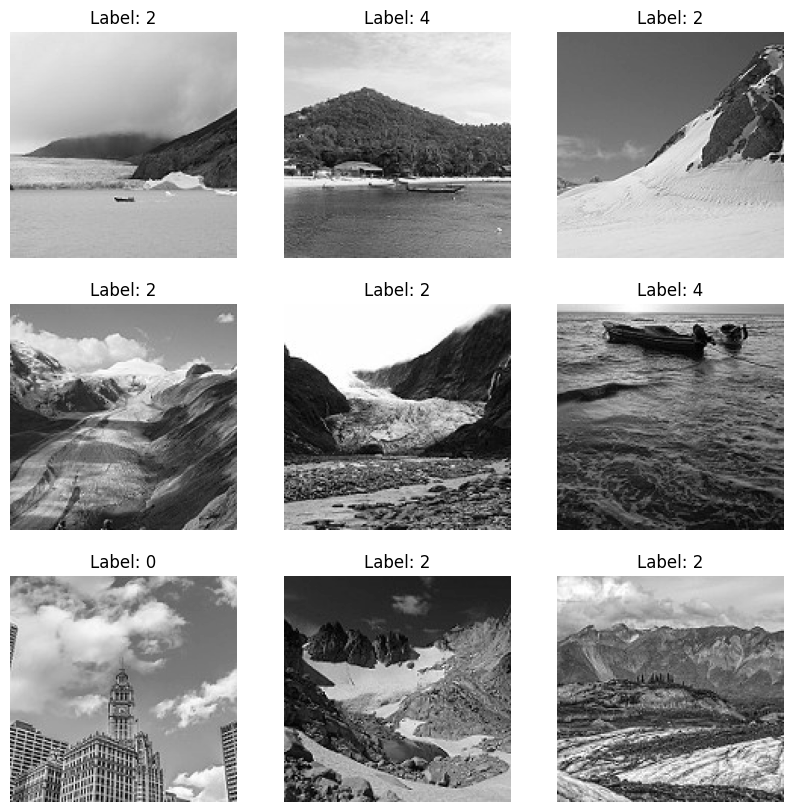

In [26]:
# Check some examples
for images, labels in train_loader:
    # Denormalize the images for plotting
    images = images * 0.5 + 0.5

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')  # images[i][0] for grayscale images
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

## Preparing Validation and Test Datasets with Stratified Sampling

In this section, we load the validation dataset, apply stratified sampling to ensure class balance, and create separate **validation** and **test** datasets.

### **Steps:**

1. **Load the Full Validation Dataset**:  
   - The dataset is located at `'/kaggle/input/intel-image-classification/seg_test/seg_test'`.
   - `datasets.ImageFolder(root=val_path, transform=transform)` loads the dataset and applies the same transformations used for training.
   - `val_dataset_full.targets` contains the class labels, which are converted into a NumPy array for stratified sampling.

2. **Perform Stratified Sampling**:  
   - `StratifiedShuffleSplit(n_splits=num_iterations, test_size=sample_size, random_state=42)` ensures that each subset maintains the same class distribution as the full dataset.
   - `num_iterations=2` creates two non-overlapping samples: one for **validation** and one for **testing**.
   - The loop iterates through the splits and extracts indices for the validation and test subsets.

3. **Assign the Samples to Validation and Test Sets**:  
   - The first sample (`sample_datasets[0]`) is used as the **validation dataset**.
   - The second sample (`sample_datasets[1]`) is used as the **test dataset**.

4. **Create DataLoaders**:  
   - The `DataLoader` is used to efficiently load data in batches.
   - A batch size of `100` is set.
   - `shuffle=False` ensures that the order remains consistent, preserving the stratified class distribution.

### **Purpose of This Approach**:
- Stratified sampling ensures that both validation and test datasets **maintain the original class distribution**, avoiding potential class imbalance issues.
- The validation dataset helps fine-tune the model, while the test dataset provides a final unbiased evaluation.

This setup ensures a fair and balanced model assessment before deploying it on unseen competition data.

In [27]:
#Validation and test data
val_path = '/kaggle/input/intel-image-classification/seg_test/seg_test'
val_dataset_full = datasets.ImageFolder(root=val_path, transform=transform)

targets = np.array(val_dataset_full.targets)  # Labels for stratification
sample_size = 100  # Total sample size

num_iterations = 2  # Number of different samples you want
# Create stratified split with multiple iterations
splitter = StratifiedShuffleSplit(n_splits=num_iterations, test_size=sample_size, random_state=42)

sample_datasets = []
for train_idx, sample_idx in splitter.split(np.zeros(len(targets)), targets):
    sample_datasets.append(Subset(val_dataset_full, sample_idx))

val_dataset = sample_datasets[0]
test_dataset = sample_datasets[1]

# Define batch size
batch_size = 100
# Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


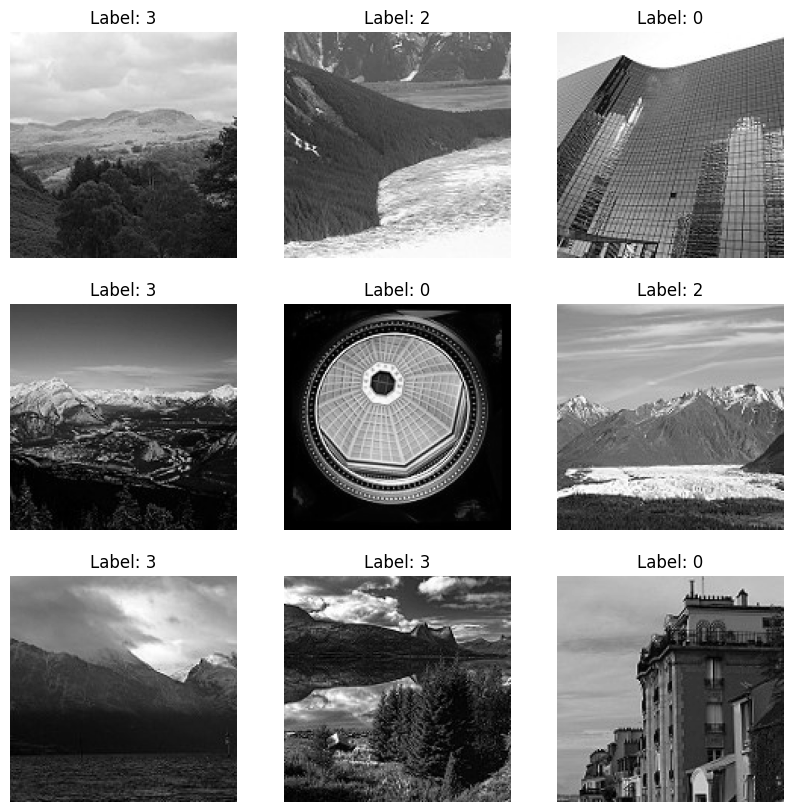

In [28]:
# Check some examples of the validation data
for images, labels in val_loader:
    # Denormalize the images for plotting
    images = images * 0.5 + 0.5

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')  # images[i][0] for grayscale images
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

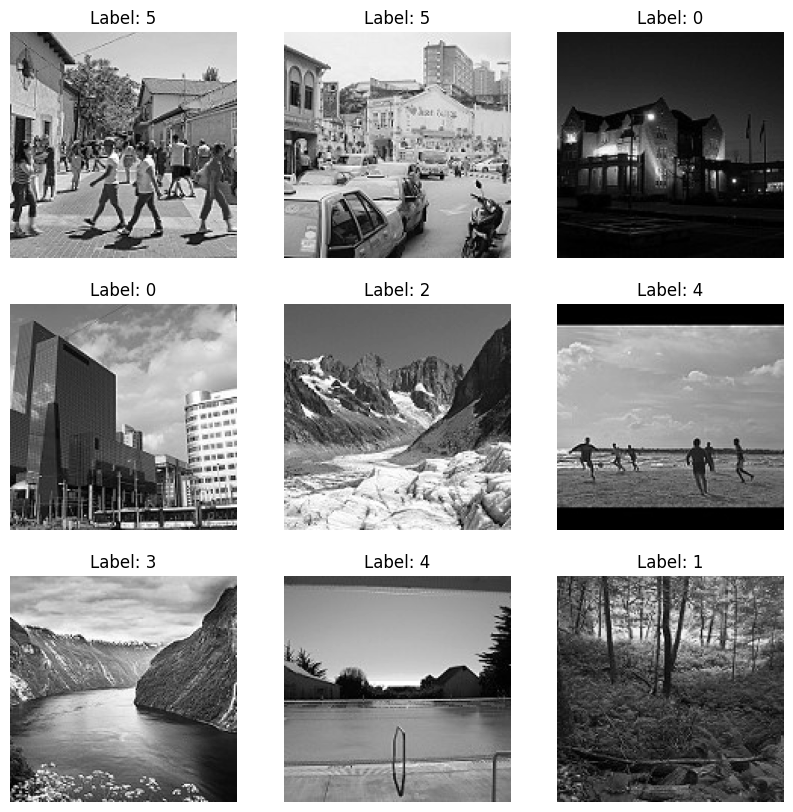

In [29]:
# Check some examples of the test data
for images, labels in test_loader:
    # Denormalize the images for plotting
    images = images * 0.5 + 0.5

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')  # images[i][0] for grayscale images
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

## Preparing the Competition Test Dataset

This section creates a dataset for the **competition test data** (`comp_test`), which consists of **unlabeled images**. The goal is to prepare these images for inference so that participants can generate predictions.

### **Steps:**

1. **List Image Files in the Directory**:  
   - The directory `'/kaggle/input/intel-image-classification/seg_pred/seg_pred'` contains the competition test images.
   - `os.listdir(image_directory)` retrieves all filenames from the directory.
   - The list is **filtered** to include only valid image file formats (`.png`, `.jpg`, `.jpeg`, `.gif`, `.bmp`).

2. **Select a Subset of Images**:  
   - The first `200` images are selected for inference using `image_files[:200]`.  
   - This ensures a manageable dataset size for predictions.

3. **Define a Custom Dataset (`SelectedFilesDataset`)**:  
   - A PyTorch `Dataset` is created to handle only the selected images.
   - It takes the **root directory** and **list of filenames** as inputs.
   - In `__getitem__`, it loads each image using `PIL.Image.open()` and converts it to **RGB** format.
   - If transformations (`transform`) are provided, they are applied before returning the image and its filename.

4. **Create the DataLoader**:  
   - `DataLoader(comp_test_dataset, batch_size=100, shuffle=False)` efficiently loads i



In [30]:
# Step 1: List the images in the directory
image_directory = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'
image_files = os.listdir(image_directory)

# Filter out only files with image extensions if necessary
image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Step 2: Select the first 200 images
image_files = image_files[:200]

class SelectedFilesDataset(Dataset):
    def __init__(self, root_dir, file_names, transform=None):
        """
        Args:
            root_dir (str): Directory where files are stored.
            file_names (list): List of selected filenames (not full paths).
            transform (callable, optional): Transformations to apply to images.
        """
        self.root_dir = root_dir
        self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(file_path).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)

        return image, self.file_names[idx]  # Return image + filename

# Example usage

comp_test_dataset = SelectedFilesDataset(image_directory, image_files, transform = transform)
comp_test_loader = DataLoader(comp_test_dataset, batch_size=100, shuffle=False)

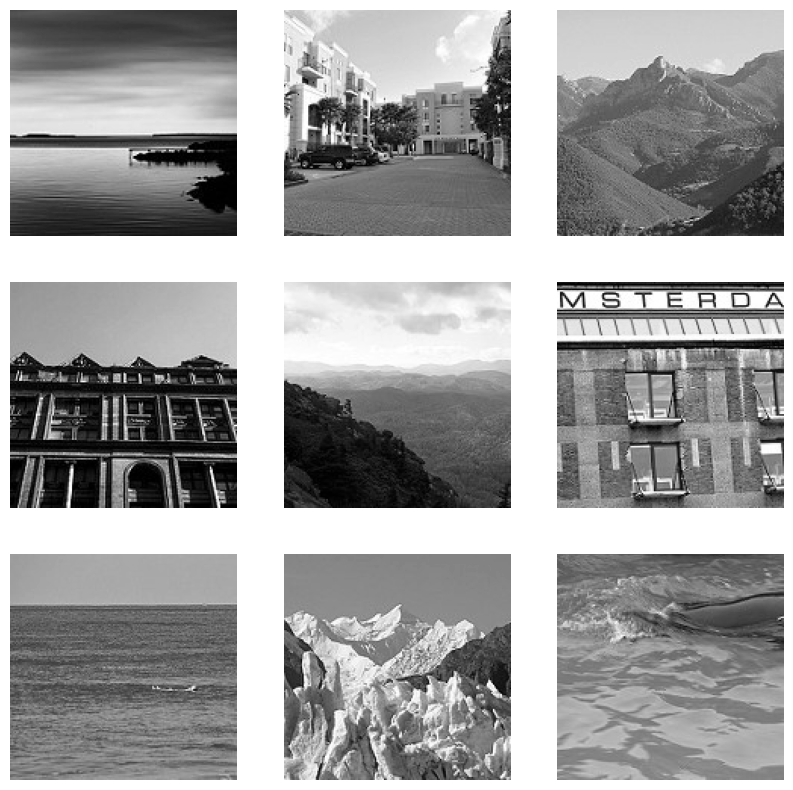

In [31]:
# Check some examples of the competition test data
for images, labels in comp_test_loader:
    # Denormalize the images for plotting
    images = images * 0.5 + 0.5

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')  # images[i][0] for grayscale images
        #plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

## **Step 2: Model Training Setup**

This step focuses on defining the **deep learning model**, setting up the **loss function**, **optimizer**, and establishing the **training loop**.

### **Define the Model Architecture**
A simple feed forward deep learning model is created for image classification. The architecture should be appropriate for the dataset, considering its complexity and number of classes.


In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import sys
PATH = '/kaggle/usr/lib/minitorchjerom/'
sys.path.insert(1, PATH)
import minitorchjerom as mytorch

In [34]:
torch.cuda.is_available()

True

In [35]:
import numpy as np
import torch
from tqdm import tqdm


def create_net(device, n_features,n_classes ):
    
    net = mytorch.Net()

    # Wider network
    net.add(mytorch.Linear(n_features, 512, device=device))  
    net.add(mytorch.BatchNorm(num_features=512, device=device))  
    net.add(mytorch.ReLU())
    net.add(mytorch.Linear(512, 256, device=device))
    net.add(mytorch.BatchNorm(num_features=256, device=device))  
    net.add(mytorch.ReLU())
    net.add(mytorch.Linear(256, 128, device=device))
    net.add(mytorch.BatchNorm(num_features=128, device=device))  
    net.add(mytorch.ReLU())
    net.add(mytorch.Linear(128, n_classes, device=device))
    
    return net


### **2. Define the Loss Function and Optimizer**
- The **loss function** (e.g., `CrossEntropyLoss`) measures how well the model's predictions match the true labels.
- The **optimizer** (e.g.,`SGD`) updates the model’s parameters to minimize the loss.

In [36]:
CELoss = mytorch.CrossEntropyFromLogits()
# Set the learning rate
learning_rate = 0.001

### **3. Training Loop**
The model is trained iteratively using:
1. **Forward pass** – The model makes predictions.
2. **Loss computation** – The difference between predictions and actual labels is calculated.
3. **Backward pass** – Gradients are computed via backpropagation.
4. **Parameter update** – The optimizer updates model weights to minimize loss.
5. **Evaluation on the validation set** – The model’s performance is monitored to avoid overfitting.

### **4. Model Evaluation on Test Set**

After training, the model's performance is assessed on the test dataset to evaluate its generalization to unseen data. This involves computing the loss and accuracy without updating model parameters, ensuring an unbiased estimate of its predictive capabilities.



In [ ]:
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm

# Hyperparameters
num_epochs = 50
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_features = 22500
n_classes = 6

version = "Definitivo"
for seed in [1001, 2025, 3107, 2403, 3141]:  # Three different seeds
    print(f"\nTraining Version {version} with Seed {seed}")
    np.random.seed(seed)
    torch.manual_seed(seed)

    net = create_net(device, n_features, n_classes)
    
    for epoch in range(1, num_epochs + 1):
        total_correct = 0
        total_samples = 0
        epoch_loss = 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Training (V{version}, Seed {seed})"), 1):
            X = images.view(images.shape[0], -1).to(device)
            Y = labels.to(device)
            Z = net.forward(X)
            loss = CELoss.forward(Z, Y)
            epoch_loss += loss.item()
            dZ = CELoss.backward(n_classes)
            dX = net.backward(dZ)
            net.update(learning_rate)
            _, predicted = torch.max(Z, 1)
            total_correct += (predicted == Y).sum().item()
            total_samples += Y.size(0)

        train_accuracy = total_correct / total_samples

        val_correct = 0
        val_samples = 0
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                X = images.view(images.shape[0], -1).to(device)
                Y = labels.to(device)
                Z = net.forward(X)
                loss = CELoss.forward(Z, Y)
                val_loss += loss.item()
                _, predicted = torch.max(Z, 1)
                val_correct += (predicted == Y).sum().item()
                val_samples += Y.size(0)

        val_accuracy = val_correct / val_samples
        print(f"V{version}, Seed {seed} - Epoch {epoch} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # Generate predictions for the competition dataset
    preds = []
    ids = []
    with torch.no_grad():
        for images, names in comp_test_loader:
            X = images.view(images.shape[0], -1).to(device)
            Z = net.forward(X)
            _, predicted = torch.max(Z, 1)
            preds.append(list(predicted.detach().cpu().numpy()))
            ids.append(list(names))

    ids = sum(ids, [])
    preds = sum(preds, [])

    if len(ids) != len(preds):
        raise ValueError("The length of file_names and pred must be the same.")

    df = pd.DataFrame({'id': ids, 'pred': preds})
    csv_file = f'predictions_V{version}_Seed{seed}.csv'
    df.to_csv(csv_file, index=False)
    print(f"CSV file '{csv_file}' created successfully.")



Training Version Definitivo with Seed 1001


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.55it/s]


VDefinitivo, Seed 1001 - Epoch 1 - Train Acc: 0.3249, Val Acc: 0.3800


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.69it/s]


VDefinitivo, Seed 1001 - Epoch 2 - Train Acc: 0.4235, Val Acc: 0.4300


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.74it/s]


VDefinitivo, Seed 1001 - Epoch 3 - Train Acc: 0.4586, Val Acc: 0.4400


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.49it/s]


VDefinitivo, Seed 1001 - Epoch 4 - Train Acc: 0.4776, Val Acc: 0.4600


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.68it/s]


VDefinitivo, Seed 1001 - Epoch 5 - Train Acc: 0.4969, Val Acc: 0.4800


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.36it/s]


VDefinitivo, Seed 1001 - Epoch 6 - Train Acc: 0.5117, Val Acc: 0.5100


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.47it/s]


VDefinitivo, Seed 1001 - Epoch 7 - Train Acc: 0.5264, Val Acc: 0.4900


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.68it/s]


VDefinitivo, Seed 1001 - Epoch 8 - Train Acc: 0.5395, Val Acc: 0.4800


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.32it/s]


VDefinitivo, Seed 1001 - Epoch 9 - Train Acc: 0.5488, Val Acc: 0.4900


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.39it/s]


VDefinitivo, Seed 1001 - Epoch 10 - Train Acc: 0.5610, Val Acc: 0.5000


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.57it/s]


VDefinitivo, Seed 1001 - Epoch 11 - Train Acc: 0.5752, Val Acc: 0.5200


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.29it/s]


VDefinitivo, Seed 1001 - Epoch 12 - Train Acc: 0.5822, Val Acc: 0.5100


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.64it/s]


VDefinitivo, Seed 1001 - Epoch 13 - Train Acc: 0.5856, Val Acc: 0.5000


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.52it/s]


VDefinitivo, Seed 1001 - Epoch 14 - Train Acc: 0.5940, Val Acc: 0.5100


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.23it/s]


VDefinitivo, Seed 1001 - Epoch 15 - Train Acc: 0.6063, Val Acc: 0.5000


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.66it/s]


VDefinitivo, Seed 1001 - Epoch 16 - Train Acc: 0.6085, Val Acc: 0.5000


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.31it/s]


VDefinitivo, Seed 1001 - Epoch 17 - Train Acc: 0.6109, Val Acc: 0.5200


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.50it/s]


VDefinitivo, Seed 1001 - Epoch 18 - Train Acc: 0.6201, Val Acc: 0.5000


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.72it/s]


VDefinitivo, Seed 1001 - Epoch 19 - Train Acc: 0.6294, Val Acc: 0.5000


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.50it/s]


VDefinitivo, Seed 1001 - Epoch 20 - Train Acc: 0.6335, Val Acc: 0.5200


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.37it/s]


VDefinitivo, Seed 1001 - Epoch 21 - Train Acc: 0.6402, Val Acc: 0.5100


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.77it/s]


VDefinitivo, Seed 1001 - Epoch 22 - Train Acc: 0.6431, Val Acc: 0.5200


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.34it/s]


VDefinitivo, Seed 1001 - Epoch 23 - Train Acc: 0.6484, Val Acc: 0.5000


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.59it/s]


VDefinitivo, Seed 1001 - Epoch 24 - Train Acc: 0.6551, Val Acc: 0.5000


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.68it/s]


VDefinitivo, Seed 1001 - Epoch 25 - Train Acc: 0.6578, Val Acc: 0.5100


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.33it/s]


VDefinitivo, Seed 1001 - Epoch 26 - Train Acc: 0.6625, Val Acc: 0.5200


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.69it/s]


VDefinitivo, Seed 1001 - Epoch 27 - Train Acc: 0.6662, Val Acc: 0.5200


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.62it/s]


VDefinitivo, Seed 1001 - Epoch 28 - Train Acc: 0.6707, Val Acc: 0.5200


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.34it/s]


VDefinitivo, Seed 1001 - Epoch 29 - Train Acc: 0.6701, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.49it/s]


VDefinitivo, Seed 1001 - Epoch 30 - Train Acc: 0.6806, Val Acc: 0.5400


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.66it/s]


VDefinitivo, Seed 1001 - Epoch 31 - Train Acc: 0.6831, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.19it/s]


VDefinitivo, Seed 1001 - Epoch 32 - Train Acc: 0.6803, Val Acc: 0.5600


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.73it/s]


VDefinitivo, Seed 1001 - Epoch 33 - Train Acc: 0.6855, Val Acc: 0.5600


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.68it/s]


VDefinitivo, Seed 1001 - Epoch 34 - Train Acc: 0.6870, Val Acc: 0.5600


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.54it/s]


VDefinitivo, Seed 1001 - Epoch 35 - Train Acc: 0.6898, Val Acc: 0.5700


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.80it/s]


VDefinitivo, Seed 1001 - Epoch 36 - Train Acc: 0.6916, Val Acc: 0.5600


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.39it/s]


VDefinitivo, Seed 1001 - Epoch 37 - Train Acc: 0.6957, Val Acc: 0.5600


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.51it/s]


VDefinitivo, Seed 1001 - Epoch 38 - Train Acc: 0.6942, Val Acc: 0.5700


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.78it/s]


VDefinitivo, Seed 1001 - Epoch 39 - Train Acc: 0.6972, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.37it/s]


VDefinitivo, Seed 1001 - Epoch 40 - Train Acc: 0.6949, Val Acc: 0.5800


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.54it/s]


VDefinitivo, Seed 1001 - Epoch 41 - Train Acc: 0.6972, Val Acc: 0.5700


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.99it/s]


VDefinitivo, Seed 1001 - Epoch 42 - Train Acc: 0.7008, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.53it/s]


VDefinitivo, Seed 1001 - Epoch 43 - Train Acc: 0.6962, Val Acc: 0.5600


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.64it/s]


VDefinitivo, Seed 1001 - Epoch 44 - Train Acc: 0.6979, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.81it/s]


VDefinitivo, Seed 1001 - Epoch 45 - Train Acc: 0.6939, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.51it/s]


VDefinitivo, Seed 1001 - Epoch 46 - Train Acc: 0.6965, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.72it/s]


VDefinitivo, Seed 1001 - Epoch 47 - Train Acc: 0.6953, Val Acc: 0.5400


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.81it/s]


VDefinitivo, Seed 1001 - Epoch 48 - Train Acc: 0.6909, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:21<00:00, 10.47it/s]


VDefinitivo, Seed 1001 - Epoch 49 - Train Acc: 0.6927, Val Acc: 0.5500


Training (VDefinitivo, Seed 1001): 100%|██████████| 220/220 [00:20<00:00, 10.86it/s]


VDefinitivo, Seed 1001 - Epoch 50 - Train Acc: 0.6933, Val Acc: 0.5400
CSV file 'predictions_VDefinitivo_Seed1001.csv' created successfully.

Training Version Definitivo with Seed 2025


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:21<00:00, 10.46it/s]


VDefinitivo, Seed 2025 - Epoch 1 - Train Acc: 0.3427, Val Acc: 0.4200


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.61it/s]


VDefinitivo, Seed 2025 - Epoch 2 - Train Acc: 0.4320, Val Acc: 0.4400


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.90it/s]


VDefinitivo, Seed 2025 - Epoch 3 - Train Acc: 0.4676, Val Acc: 0.4700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.81it/s]


VDefinitivo, Seed 2025 - Epoch 4 - Train Acc: 0.4907, Val Acc: 0.4700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:21<00:00, 10.47it/s]


VDefinitivo, Seed 2025 - Epoch 5 - Train Acc: 0.5110, Val Acc: 0.4700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.80it/s]


VDefinitivo, Seed 2025 - Epoch 6 - Train Acc: 0.5277, Val Acc: 0.4900


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.50it/s]


VDefinitivo, Seed 2025 - Epoch 7 - Train Acc: 0.5369, Val Acc: 0.4800


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.64it/s]


VDefinitivo, Seed 2025 - Epoch 8 - Train Acc: 0.5507, Val Acc: 0.4600


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.72it/s]


VDefinitivo, Seed 2025 - Epoch 9 - Train Acc: 0.5622, Val Acc: 0.4700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.69it/s]


VDefinitivo, Seed 2025 - Epoch 10 - Train Acc: 0.5707, Val Acc: 0.4800


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.72it/s]


VDefinitivo, Seed 2025 - Epoch 11 - Train Acc: 0.5837, Val Acc: 0.4600


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.89it/s]


VDefinitivo, Seed 2025 - Epoch 12 - Train Acc: 0.5874, Val Acc: 0.4800


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.54it/s]


VDefinitivo, Seed 2025 - Epoch 13 - Train Acc: 0.5995, Val Acc: 0.4800


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.71it/s]


VDefinitivo, Seed 2025 - Epoch 14 - Train Acc: 0.6048, Val Acc: 0.4900


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.91it/s]


VDefinitivo, Seed 2025 - Epoch 15 - Train Acc: 0.6133, Val Acc: 0.4900


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.77it/s]


VDefinitivo, Seed 2025 - Epoch 16 - Train Acc: 0.6132, Val Acc: 0.4900


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.67it/s]


VDefinitivo, Seed 2025 - Epoch 17 - Train Acc: 0.6201, Val Acc: 0.5000


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.06it/s]


VDefinitivo, Seed 2025 - Epoch 18 - Train Acc: 0.6290, Val Acc: 0.5000


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.74it/s]


VDefinitivo, Seed 2025 - Epoch 19 - Train Acc: 0.6348, Val Acc: 0.4900


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.62it/s]


VDefinitivo, Seed 2025 - Epoch 20 - Train Acc: 0.6420, Val Acc: 0.4900


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.18it/s]


VDefinitivo, Seed 2025 - Epoch 21 - Train Acc: 0.6459, Val Acc: 0.5000


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.80it/s]


VDefinitivo, Seed 2025 - Epoch 22 - Train Acc: 0.6511, Val Acc: 0.4900


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.05it/s]


VDefinitivo, Seed 2025 - Epoch 23 - Train Acc: 0.6543, Val Acc: 0.5200


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.31it/s]


VDefinitivo, Seed 2025 - Epoch 24 - Train Acc: 0.6580, Val Acc: 0.5000


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.92it/s]


VDefinitivo, Seed 2025 - Epoch 25 - Train Acc: 0.6590, Val Acc: 0.5000


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.10it/s]


VDefinitivo, Seed 2025 - Epoch 26 - Train Acc: 0.6601, Val Acc: 0.5300


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.30it/s]


VDefinitivo, Seed 2025 - Epoch 27 - Train Acc: 0.6626, Val Acc: 0.5300


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.04it/s]


VDefinitivo, Seed 2025 - Epoch 28 - Train Acc: 0.6684, Val Acc: 0.5200


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.02it/s]


VDefinitivo, Seed 2025 - Epoch 29 - Train Acc: 0.6685, Val Acc: 0.5400


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.31it/s]


VDefinitivo, Seed 2025 - Epoch 30 - Train Acc: 0.6709, Val Acc: 0.5400


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.91it/s]


VDefinitivo, Seed 2025 - Epoch 31 - Train Acc: 0.6681, Val Acc: 0.5500


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.06it/s]


VDefinitivo, Seed 2025 - Epoch 32 - Train Acc: 0.6732, Val Acc: 0.5500


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.91it/s]


VDefinitivo, Seed 2025 - Epoch 33 - Train Acc: 0.6737, Val Acc: 0.5500


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.65it/s]


VDefinitivo, Seed 2025 - Epoch 34 - Train Acc: 0.6749, Val Acc: 0.5600


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:21<00:00, 10.42it/s]


VDefinitivo, Seed 2025 - Epoch 35 - Train Acc: 0.6754, Val Acc: 0.5600


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.64it/s]


VDefinitivo, Seed 2025 - Epoch 36 - Train Acc: 0.6794, Val Acc: 0.5500


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.78it/s]


VDefinitivo, Seed 2025 - Epoch 37 - Train Acc: 0.6786, Val Acc: 0.5700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.67it/s]


VDefinitivo, Seed 2025 - Epoch 38 - Train Acc: 0.6792, Val Acc: 0.5700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.74it/s]


VDefinitivo, Seed 2025 - Epoch 39 - Train Acc: 0.6756, Val Acc: 0.5700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.88it/s]


VDefinitivo, Seed 2025 - Epoch 40 - Train Acc: 0.6759, Val Acc: 0.5700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.96it/s]


VDefinitivo, Seed 2025 - Epoch 41 - Train Acc: 0.6775, Val Acc: 0.5600


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.09it/s]


VDefinitivo, Seed 2025 - Epoch 42 - Train Acc: 0.6739, Val Acc: 0.5700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.98it/s]


VDefinitivo, Seed 2025 - Epoch 43 - Train Acc: 0.6751, Val Acc: 0.5900


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.23it/s]


VDefinitivo, Seed 2025 - Epoch 44 - Train Acc: 0.6793, Val Acc: 0.5700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.06it/s]


VDefinitivo, Seed 2025 - Epoch 45 - Train Acc: 0.6753, Val Acc: 0.5700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.93it/s]


VDefinitivo, Seed 2025 - Epoch 46 - Train Acc: 0.6753, Val Acc: 0.5700


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:19<00:00, 11.09it/s]


VDefinitivo, Seed 2025 - Epoch 47 - Train Acc: 0.6763, Val Acc: 0.5500


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.51it/s]


VDefinitivo, Seed 2025 - Epoch 48 - Train Acc: 0.6712, Val Acc: 0.5800


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:21<00:00, 10.37it/s]


VDefinitivo, Seed 2025 - Epoch 49 - Train Acc: 0.6697, Val Acc: 0.5800


Training (VDefinitivo, Seed 2025): 100%|██████████| 220/220 [00:20<00:00, 10.49it/s]


VDefinitivo, Seed 2025 - Epoch 50 - Train Acc: 0.6695, Val Acc: 0.5700
CSV file 'predictions_VDefinitivo_Seed2025.csv' created successfully.

Training Version Definitivo with Seed 3107


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.64it/s]


VDefinitivo, Seed 3107 - Epoch 1 - Train Acc: 0.3116, Val Acc: 0.4200


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.60it/s]


VDefinitivo, Seed 3107 - Epoch 2 - Train Acc: 0.4146, Val Acc: 0.4000


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.89it/s]


VDefinitivo, Seed 3107 - Epoch 3 - Train Acc: 0.4513, Val Acc: 0.4600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.58it/s]


VDefinitivo, Seed 3107 - Epoch 4 - Train Acc: 0.4781, Val Acc: 0.4500


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.52it/s]


VDefinitivo, Seed 3107 - Epoch 5 - Train Acc: 0.4927, Val Acc: 0.4500


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.61it/s]


VDefinitivo, Seed 3107 - Epoch 6 - Train Acc: 0.5079, Val Acc: 0.4600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.42it/s]


VDefinitivo, Seed 3107 - Epoch 7 - Train Acc: 0.5244, Val Acc: 0.4800


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.47it/s]


VDefinitivo, Seed 3107 - Epoch 8 - Train Acc: 0.5385, Val Acc: 0.4800


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.94it/s]


VDefinitivo, Seed 3107 - Epoch 9 - Train Acc: 0.5492, Val Acc: 0.5200


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.56it/s]


VDefinitivo, Seed 3107 - Epoch 10 - Train Acc: 0.5549, Val Acc: 0.5400


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.84it/s]


VDefinitivo, Seed 3107 - Epoch 11 - Train Acc: 0.5661, Val Acc: 0.5300


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.71it/s]


VDefinitivo, Seed 3107 - Epoch 12 - Train Acc: 0.5788, Val Acc: 0.5400


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.20it/s]


VDefinitivo, Seed 3107 - Epoch 13 - Train Acc: 0.5824, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.47it/s]


VDefinitivo, Seed 3107 - Epoch 14 - Train Acc: 0.5857, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.62it/s]


VDefinitivo, Seed 3107 - Epoch 15 - Train Acc: 0.6018, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.37it/s]


VDefinitivo, Seed 3107 - Epoch 16 - Train Acc: 0.6042, Val Acc: 0.5800


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.78it/s]


VDefinitivo, Seed 3107 - Epoch 17 - Train Acc: 0.6127, Val Acc: 0.5800


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.70it/s]


VDefinitivo, Seed 3107 - Epoch 18 - Train Acc: 0.6159, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.20it/s]


VDefinitivo, Seed 3107 - Epoch 19 - Train Acc: 0.6248, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:23<00:00,  9.52it/s]


VDefinitivo, Seed 3107 - Epoch 20 - Train Acc: 0.6308, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.76it/s]


VDefinitivo, Seed 3107 - Epoch 21 - Train Acc: 0.6330, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.60it/s]


VDefinitivo, Seed 3107 - Epoch 22 - Train Acc: 0.6389, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.89it/s]


VDefinitivo, Seed 3107 - Epoch 23 - Train Acc: 0.6477, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.54it/s]


VDefinitivo, Seed 3107 - Epoch 24 - Train Acc: 0.6497, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.54it/s]


VDefinitivo, Seed 3107 - Epoch 25 - Train Acc: 0.6553, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.66it/s]


VDefinitivo, Seed 3107 - Epoch 26 - Train Acc: 0.6598, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.23it/s]


VDefinitivo, Seed 3107 - Epoch 27 - Train Acc: 0.6619, Val Acc: 0.5900


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.15it/s]


VDefinitivo, Seed 3107 - Epoch 28 - Train Acc: 0.6670, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.58it/s]


VDefinitivo, Seed 3107 - Epoch 29 - Train Acc: 0.6645, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.40it/s]


VDefinitivo, Seed 3107 - Epoch 30 - Train Acc: 0.6696, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.40it/s]


VDefinitivo, Seed 3107 - Epoch 31 - Train Acc: 0.6734, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.54it/s]


VDefinitivo, Seed 3107 - Epoch 32 - Train Acc: 0.6788, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.40it/s]


VDefinitivo, Seed 3107 - Epoch 33 - Train Acc: 0.6781, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.67it/s]


VDefinitivo, Seed 3107 - Epoch 34 - Train Acc: 0.6852, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.50it/s]


VDefinitivo, Seed 3107 - Epoch 35 - Train Acc: 0.6868, Val Acc: 0.5500


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.25it/s]


VDefinitivo, Seed 3107 - Epoch 36 - Train Acc: 0.6907, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.64it/s]


VDefinitivo, Seed 3107 - Epoch 37 - Train Acc: 0.6898, Val Acc: 0.5700


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.71it/s]


VDefinitivo, Seed 3107 - Epoch 38 - Train Acc: 0.6940, Val Acc: 0.5600


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.54it/s]


VDefinitivo, Seed 3107 - Epoch 39 - Train Acc: 0.6907, Val Acc: 0.5800


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.80it/s]


VDefinitivo, Seed 3107 - Epoch 40 - Train Acc: 0.6945, Val Acc: 0.5800


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:20<00:00, 10.58it/s]


VDefinitivo, Seed 3107 - Epoch 41 - Train Acc: 0.6966, Val Acc: 0.5500


Training (VDefinitivo, Seed 3107): 100%|██████████| 220/220 [00:21<00:00, 10.28it/s]


VDefinitivo, Seed 3107 - Epoch 42 - Train Acc: 0.6950, Val Acc: 0.5900


Training (VDefinitivo, Seed 3107):  63%|██████▎   | 139/220 [00:13<00:07, 10.62it/s]

In [ ]:
# Validation Phase
test_correct = 0
test_samples = 0
test_loss = 0
test_loss_history = []

with torch.no_grad():  # Disable gradient calculation for validation
    for images, labels in test_loader:
        X = images.view(images.shape[0], -1).to(device)
        Y = labels.to(device)

        # Forward pass
        Z = best_model.forward(X)

        # Compute loss
        loss = CELoss.forward(Z, Y)
        test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(Z, 1)
        test_correct += (predicted == Y).sum().item()
        test_samples += Y.size(0)

# Compute validation loss and accuracy
test_loss /= len(test_loader)
test_accuracy = test_correct / test_samples
test_loss_history.append(test_loss)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

### **5. Generating Predictions for the Competition Test Set**

After training and validating the model, the next step is to generate predictions for the comp_test dataset, which contains unlabeled data. This involves processing the dataset through the trained model to obtain predicted labels. These predictions are then formatted according to the competition's submission requirements, a CSV file with each image's filename and its corresponding predicted label. This submission file is then uploaded to the competition platform for evaluation against the hidden ground-truth labels.


In [ ]:
preds = []
ids = []
with torch.no_grad():  # Disable gradient calculation for validation
    for images,names in comp_test_loader:
        X = images.view(images.shape[0], -1).to(device)

        # Forward pass
        Z = best_model.forward(X)
        _, predicted = torch.max(Z, 1)
        preds.append(list(predicted.detach().cpu().numpy()))
        ids.append(list(names))

In [ ]:
import pandas as pd

ids = sum(ids,[])
preds = sum(preds,[])


# Ensure file_names and pred have the same length
if len(ids) != len(preds):
    raise ValueError("The length of file_names and pred must be the same.")

# Create a DataFrame from the file_names and pred lists
df = pd.DataFrame({
    'id': ids,
    'pred': preds
})

# Define the CSV file name
csv_file = 'predictions.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file, index=False)

print(f"CSV file '{csv_file}' created successfully.")

The file can be downloaded from the folder /kaggle/working